## Obtaining coordinates from a FI network using UMAP

In [1]:
# Importing necessary libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap

In [2]:
# Importing Node2Vec embeddings
emb = pd.read_csv('n2v-out.emb', skiprows = 1, sep = ' ', header = None, index_col=0)
emb_data = emb.to_numpy()
emb_labels = emb.index.to_numpy()

In [2]:
# UMAP
umap_emb = umap.UMAP(
    n_epochs = 400,
    random_state = 42,
    metric = 'dice',
    output_metric = 'mahalanobis'
).fit_transform(emb_data)

np.save('umap_emb', umap_emb)

/home/paul/.local/share/virtualenvs/bioeng-project-xx9s03MZ/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


In [3]:
umap_emb = np.load('umap_emb.npy')

In [4]:
umap_emb_x, umap_emb_y = zip(*umap_emb)
umap_coord = pd.DataFrame([emb_labels, umap_emb_x, umap_emb_y]).transpose().rename(columns = {0: 'node_id', 1: 'x', 2: 'y'})

In [5]:
normal_umap_coord_x = umap_coord['x'].apply(lambda v: (v - umap_coord['x'].min()) / (umap_coord['x'].max() - umap_coord['x'].min()) * 300).round()
normal_umap_coord_y = umap_coord['y'].apply(lambda v: (v - umap_coord['y'].min()) / (umap_coord['y'].max() - umap_coord['y'].min()) * 300).round()
normal_umap_coord = pd.DataFrame([umap_coord['node_id'], normal_umap_coord_x, normal_umap_coord_y]).transpose().round(3).astype(int)

In [6]:
normal_umap_coord

,node_id,x,y
0,4923,253,163
1,1059,264,149
2,145,252,167
3,872,256,91
4,2304,262,102
...,...,...,...
10951,8980,167,162
10952,10114,222,162
10953,8022,180,203
10954,10670,128,262


In [53]:
nimg = np.zeros((300, 300, 3)).astype('uint8')

## Obtaining the template for UniProt/ENSEMBL/node id conversions

In [54]:
network = pd.read_csv('FIs_043009.txt', header=None, sep = ' ').rename(columns = {0: 'from', 1: 'to'})
biomart = pd.read_csv('mart_export.tsv', sep='\t')
used_uprots = pd.read_csv('node_id_name.tsv', sep='\t').rename(columns = {'name': 'UniProtKB Gene Name ID'})

human_genes = biomart.drop_duplicates(subset = 'Gene stable ID', keep = 'first', ignore_index = True).sort_values(by = 'Gene stable ID', ignore_index = True).dropna(subset = ['UniProtKB Gene Name ID', 'UniProtKB/Swiss-Prot ID', 'UniProtKB/TrEMBL ID'], how = 'all').fillna(axis = 1, method = 'bfill').drop(columns = ['UniProtKB/Swiss-Prot ID', 'UniProtKB/TrEMBL ID'])

In [55]:
human_genes

,Gene stable ID,UniProtKB Gene Name ID
0,ENSG00000000003,O43657
1,ENSG00000000005,Q9H2S6
2,ENSG00000000419,O60762
3,ENSG00000000457,Q8IZE3
4,ENSG00000000460,Q9NSG2
...,...,...
22788,ENSG00000288513,Q96R69
22789,ENSG00000288516,P17612
22791,ENSG00000288520,G9CGD6
22793,ENSG00000288534,H3BSU7


In [56]:
used_uprots

,UniProtKB Gene Name ID,node_id
0,Q494X3,1
1,P26006,2
2,O43296,3
3,P83876,4
4,O95622,5
...,...,...
10951,Q8WU10,10952
10952,P12277,10953
10953,Q96T51,10954
10954,Q8ND90,10955


In [57]:
template = pd.merge(human_genes, used_uprots, how = 'inner', on = 'UniProtKB Gene Name ID')

In [58]:
template

,Gene stable ID,UniProtKB Gene Name ID,node_id
0,ENSG00000000419,O60762,6479
1,ENSG00000000938,P09769,2261
2,ENSG00000001084,P48506,5576
3,ENSG00000001167,P23511,5652
4,ENSG00000001617,Q13275,5484
...,...,...,...
10223,ENSG00000285053,Q15813,2744
10224,ENSG00000284194,O43819,6667
10225,ENSG00000284723,Q8NH09,10415
10226,ENSG00000286169,A9YTQ3,4206


In [59]:
tempdata = pd.merge(normal_umap_coord, template, on = 'node_id')

In [60]:
brcaex = pd.read_csv('brca.csv').rename(columns = {'Unnamed: 0': 'Gene stable ID'})

In [61]:
patientex = brcaex.iloc[:, :2]

In [62]:
coorex = pd.merge(tempdata, patientex).sort_values(by = 'Gene stable ID', ignore_index = True).drop(columns = ['node_id']).groupby(['x', 'y']).mean().round().astype(int)

In [63]:
((k, l), m) = zip(*coorex.index), coorex.iloc[:, -1].values

In [64]:
coorex

83acd71c-c12a-4394-ba8d-05e9c5ad2cf1
x   y                                        
0   128                                     0
    133                                     0
    134                                     0
1   124                                     0
    130                                     0
...                                       ...
299 135                                  7567
    136                                 11438
300 92                                   9663
    135                                 16147
    136                                 13924

[6951 rows x 1 columns]

In [65]:
for i in range(len(k)):
    b = m[i] & 255
    g = (m[i] >> 8) & 255
    r = (m[i] >> 16) & 255
    
    if k[i] == 300 or l[i] == 300:
        continue
        
    nimg[k[i]][l[i]] = [r, g, b]

True

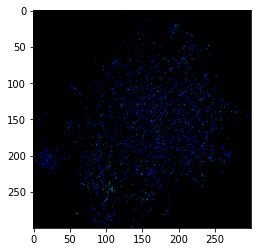

In [66]:
plt.imshow(nimg)
cv2.imwrite('finalpic.png', cv2.cvtColor(nimg, cv2.COLOR_BGR2RGB))